# size of figure
Size of nanostructures: Minimum of 500nm, maximum 5$\mu$m

Spacing:1-3 micrometer mellom

In [ ]:
def test_shapes(arr:np.array):
    if not len(arr.shape) == 3: # testing (n,m,l), whereas the next tests if l=3
        raise ValueError(f'Your bitmap is not on the form (n,m,l), but {arr.shape}')

    if not arr.shape[-1]  == 3: # testing (n,m,3)
        raise ValueError(f'Your bitmap is not on the form (n,m,3), but {arr.shape}')


def test_rgb_identical(arr:np.array):
    for i in range(1,arr.shape[-1]):
        if np.all(arr[:,:,0] == arr[:,:,i]):
            pass
        else:
            print('Warning: Not all RGB color channels are identical')

def test_max_min(arr:np.array):
    if not arr.max() == 255:
        print(f'Warning: Maximum value is not 255 but {arr.max()}')
    if not arr.min() == 0:
        print(f'Warning: Minimum value is not 0 but {arr.min()}')

    if arr.max() > 255:
        raise ValueError('Max value exceeding limits')
    if arr.min() < 0:
        raise ValueError('Minimum value less than 0')

def is_binary(arr:np.array):
    if not np.all((arr == 0) | (arr == 255)):
        print('FYI: This is not a binary bitmap. This is not a problem, but some pixels will be milled/deposited with a smaller dwell time. If you want to make it binary, try to threshold it.')

def test_dtype(arr: np.array):
    if arr.dtype != np.uint8:
        raise TypeError('dtype is not np.uint8!')


def run_tests(arr:np.array):
    """Takes in the *.bmp file as a numpy array and test a couple of formalities."""
    test_max_min(arr)
    test_rgb_identical(arr)
    is_binary(arr)
    test_dtype(arr)


(1024, 512)
Test starting
Test ended
(1024, 512)
Test starting
Test ended
(1024, 512)
Test starting
Test ended
(512, 512)
Test starting
Test ended


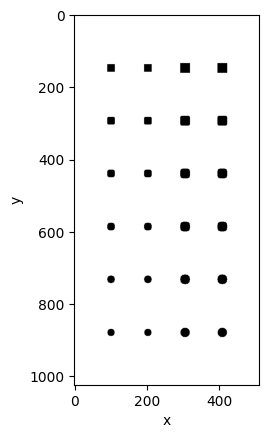

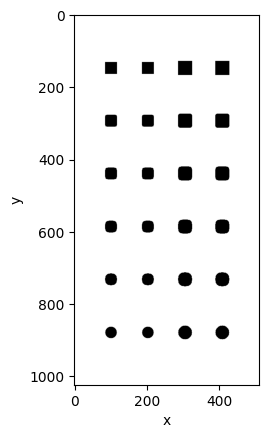

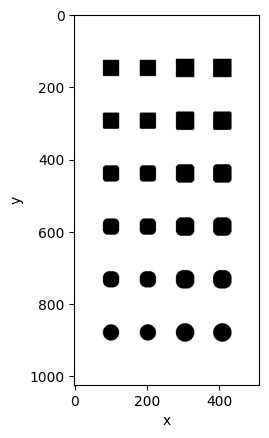

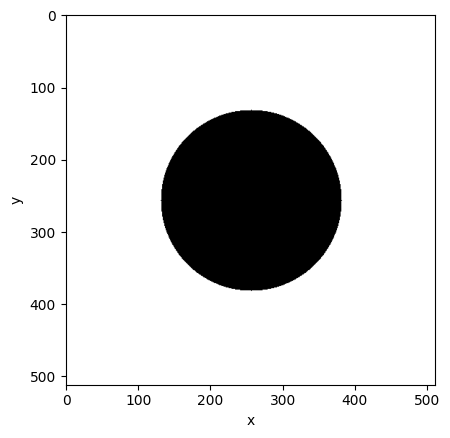

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as nd
from skimage.draw import polygon
from skimage.morphology import footprints

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import shutil

DATA_FOLDER = "bitmaps"

def numpy_to_bmp(arr: np.array, fname:str=None):
    """Converts a (n,m) numpy array to bmp file. Assumes that the numpy array has values in the interval [0,1]"""
    assert len(arr.shape) == 2
    assert arr.min()==0
    assert arr.max()==1
    img = np.zeros((*arr.shape, 3))

    img[:,:,0] = arr
    img[:,:,1] = arr
    img[:,:,2] = arr
    pilimg = Image.fromarray(np.uint8(img*255))
    if fname is None:
        return pilimg
    pilimg.save(fname)
    img = plt.imread(fname)
    print('Test starting')
    run_tests(img)
    print('Test ended')



plt.rcParams['image.cmap'] = 'gray'



def get_grid2(sh,offset,spacing, f, *args):
    """
    Convenient for creating a millingpattern for 2D investigations.
    Parameters:
    -------------
        sh, offset, spacing

        f:
            Function that creates the different elements. The grid will change the first argument left to right and the second argument top to bottom.
        *args
            Passed to f.

    Example
    -------------
        See below

    """
    ngrid= np.zeros(sh)
    reference = np.zeros(sh)
    for i,j in enumerate(np.arange(offset, sh[0]-offset, spacing)):
        for k,l in enumerate(np.arange(offset, sh[1]-offset, spacing)):
            element = f(i,k, *args)
            ex,ey = element.shape
            ngrid[l-ex//2:l+ex//2 + ex%2,j-ey//2:j+ey//2+ey%2] = element
            reference[l,j] = 1
    com = (np.array(nd.center_of_mass(reference)) - np.array(sh)//2).astype(int)
    return np.roll(np.invert(ngrid.astype(bool)), -com,axis=[0,1])

def get_grid2_custom(resolution, f, count_x=6, count_y=3, *args):
    """
    Convenient for creating a millingpattern for 2D investigations.
    Parameters:
    -------------
        sh, offset, spacing

        f:
            Function that creates the different elements. The grid will change the first argument left to right and the second argument top to bottom.
        *args
            Passed to f.

    Example
    -------------
        See below

    """



    element_shape = f(count_x-1,count_y-1, *args).shape

    offset_x = int(resolution[0]/(count_x+1)) #int(element_shape[0]/2) + 10
    offset_y = int(resolution[1]/(count_y+1)) #int(element_shape[1]/2) + 10


    ngrid= np.zeros(resolution)
    print(ngrid.shape)

    reference = np.zeros(resolution)
    for x_index,x_position in enumerate(np.linspace(offset_x, resolution[0]-offset_x, count_x)):
        for y_index,y_position in enumerate(np.linspace(offset_y, resolution[1]-offset_y, count_y)):
            element = f(x_index,y_index, *args)
            ex,ey = element.shape
            #print(ngrid.shape)
            #print(int(x_position)-ey//2, int(x_position)+ey//2+ey%2)
            #print(ngrid[int(y_position)-ex//2:int(y_position)+ex//2 + ex%2,int(x_position)-ey//2:int(x_position)+ey//2+ey%2].shape)
            #print(int(x_position)-ey//2, int(x_position)+ey//2+ey%2)
            ngrid[int(x_position)-ex//2:int(x_position)+ex//2 + ex%2,int(y_position)-ey//2:int(y_position)+ey//2+ey%2] = element
            reference[int(x_position), int(y_position)] = 1
    com = (np.array(nd.center_of_mass(reference)) - np.array(resolution)//2).astype(int)
    return np.roll(np.invert(ngrid.astype(bool)), -com,axis=[0,1])



def lerp(a,b,x):
    return a*(1-x) + b*(x)



def get_squircle_window(start_index, end_index, figure_widths, count=6):
  def get_squircle(N_x, N_y, scale):
    """
    Produces an ellipse. Radius changes with N as radius =  N+7 and rotation as rotation=k*10 degrees"""
    # Count is number of figures from square to circle
    size = figure_widths[N_y]
    radius = lerp(0, size, (N_x+start_index)/(count-1))
    x = np.arange(-size,size+1)*2
    y = np.arange(-size,size+1)*2
    xx,yy = np.meshgrid(x,y,indexing='ij')

    cross_width = size - radius
    circle_x_position = abs(size) - radius
    circle_y_position = abs(size) - radius

    pixels = np.logical_or(
        np.logical_and((xx**2) <= size**2, (yy**2) <= cross_width**2),
        np.logical_or(
            np.logical_and((yy**2) <= size**2, (xx**2) <= cross_width**2),
            (np.abs(xx)-circle_x_position)**2 + (np.abs(yy) - circle_y_position)**2 <= radius**2
        )
    )

    #pixels = (np.abs(xx)-circle_x_position)**2 + (np.abs(yy) - circle_y_position)**2 <= radius**2
    return pixels #unrotated #nd.rotate(unrotated, rotation, order=0) # Rotation in degrees

  return get_squircle

def create_bitmap(filename, sizes_in_pixels, start_index, end_index, count=6, resolution = (512,512)):
  """
  size: Amount of pixels in width of each figure
  """

  offset = int(np.mean(sizes_in_pixels)/2) + 1
  spacing = int((512-offset*2)/3)
  scale=1
  plt.figure()


  bitmap_numpy_array = get_grid2_custom(resolution, get_squircle_window(start_index, end_index, sizes_in_pixels), end_index-start_index + 1, len(sizes_in_pixels), scale)
  plt.imshow(bitmap_numpy_array)

  bitmap = numpy_to_bmp(bitmap_numpy_array, filename)

  plt.xlabel('x')
  plt.ylabel('y')


def create_windows():

  size_of_window_in_nm = 10_000 # size of each figure
  sizes_in_nm = np.linspace(200, 500, 6, dtype=np.int32) # size of each figure

  temp = []
  for size in sizes_in_nm:
    temp.append(size)
    temp.append(size)
  sizes_in_nm = np.array(temp)

  sizes_in_nm = sizes_in_nm.reshape((3, 4))

  def to_pixel_size(size_in_nm, resolution):
    return int(size_in_nm/size_of_window_in_nm*resolution[0])


  for sizes_in_nm_bitmap in sizes_in_nm:
    #if sizes_in_nm_bitmap <= 200:
    #  resolution = (1024, 1024)
    #else:
    resolution = (1024, 512)

    sizes_in_pixels_bitmap = np.array(list(map(lambda x:to_pixel_size(x, resolution), sizes_in_nm_bitmap)))

    create_bitmap(f"{DATA_FOLDER}/bitmap-size-{str(sizes_in_nm_bitmap).zfill(4)}nm.bmp", sizes_in_pixels_bitmap, 0, 5, resolution=resolution)
    #create_bitmap(f"{DATA_FOLDER}/bitmap-size-{str(sizes_in_nm_bitmap).zfill(4)}nm-part2.bmp", sizes_in_pixels_bitmap, 3, 5, resolution=resolution)

  resolution = (512,512)
  create_bitmap(f"{DATA_FOLDER}/bitmap-magnetic-compass.bmp", np.array([to_pixel_size(4_900, resolution)]), 5, 5)

if os.path.exists(DATA_FOLDER) and os.path.isdir(DATA_FOLDER):
    shutil.rmtree(DATA_FOLDER)

os.makedirs(DATA_FOLDER, exist_ok=True)

create_windows()

In [ ]:
!zip -r bitmaps.zip bitmaps
from google.colab import files
files.download("bitmaps.zip")

updating: bitmaps/ (stored 0%)
updating: bitmaps/bitmap-magnetic-compass.bmp (deflated 100%)
  adding: bitmaps/bitmap-size-[200 200 260 260]nm.bmp (deflated 100%)
  adding: bitmaps/bitmap-size-[440 440 500 500]nm.bmp (deflated 100%)
  adding: bitmaps/bitmap-size-[320 320 380 380]nm.bmp (deflated 100%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>